# Extract structured data from images

Use AI vision to extract JSON data from receipts, forms, documents, and other images.

## Problem

You have images containing structured information (receipts, forms, ID cards) and need to extract specific fields as JSON for downstream processing.

| Image | Fields to extract |
|-------|------------------|
| receipt.jpg | vendor, total, date, items |
| business_card.jpg | name, email, phone, company |
| invoice.pdf | invoice_number, amount, due_date |

## Solution

**What's in this recipe:**

- Extract structured JSON from images using GPT-4o
- Use `openai.vision()` which handles images directly
- Access individual fields from the extracted data

You use Pixeltable's `openai.vision()` function which automatically handles image encoding. Request JSON output via `response_format` in `model_kwargs`.

### Setup

In [ ]:
%pip install -qU pixeltable openai

import getpass
import os

if 'OPENAI_API_KEY' not in os.environ:
    os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key: ')

In [1]:
import pixeltable as pxt
from pixeltable.functions import openai

### Load images

In [2]:
# Create a fresh directory
pxt.drop_dir('extraction_demo', force=True)
pxt.create_dir('extraction_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata
Created directory 'extraction_demo'.


In [3]:
t = pxt.create_table('extraction_demo/images', {'image': pxt.Image})

Created table 'images'.


In [4]:
# Insert sample images
t.insert(
    [
        {
            'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000036.jpg'
        },
        {
            'image': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000090.jpg'
        },
    ]
)

Inserted 2 rows with 0 errors in 0.03 s (60.43 rows/s)


2 rows inserted.

### Extract structured data

Use `openai.chat_completions()` to analyze images and get JSON output:

In [6]:
# Add extraction column using openai.vision (handles images directly)
PROMPT = """Analyze this image and extract the following as JSON:
- description: A brief description of the image
- objects: List of objects visible in the image
- dominant_colors: List of dominant colors
- scene_type: Type of scene (indoor, outdoor, etc.)"""

messages = [
    {
        'role': 'user',
        'content': [
            {'type': 'text', 'text': PROMPT},
            {'type': 'image_url', 'image_url': t.image},
        ]
    }
]

t.add_computed_column(
    data=openai.chat_completions(
        messages,
        model='gpt-4o-mini',
        model_kwargs={'response_format': {'type': 'json_object'}},
    )
)

Added 2 column values with 0 errors in 7.55 s (0.26 rows/s)


2 rows updated.

image,data,data_choices0_message_content
,"{""id"": ""chatcmpl-DCZGQMTD4imtZ6xI1Z6rwiebHO5Jd"", ""model"": ""gpt-4o-mini-2024-07-18"", ""usage"": {""total_tokens"": 14327, ""prompt_tokens"": 14229, ""completion_tokens"": 98, ""prompt_tokens_details"": {""audio_tokens"": 0, ""cached_tokens"": 0}, ""completion_tokens_details"": {""audio_tokens"": 0, ""reasoning_tokens"": 0, ""accepted_prediction_tokens"": 0, ""rejected_prediction_tokens"": 0}}, ""object"": ""chat.completion"", ""choices"": [{""index"": 0, ""message"": {""role"": ""assistant"", ""content"": ""{\n \""description\"": \""A woman holding a pink umbrella and wearing a colorful swimsuit, smiling against a backdrop of a lake and blue sky.\"",\n \""objec ...... \""sky\"",\n \""trees\""\n ],\n \""dominant_colors\"": [\n \""pink\"",\n \""blue\"",\n \""green\"",\n \""white\"",\n \""purple\""\n ],\n \""scene_type\"": \""outdoor\""\n}"", ""refusal"": null, ""annotations"": []}, ""logprobs"": null, ""finish_reason"": ""stop""}], ""created"": 1771887862, ""service_tier"": ""default"", ""system_fingerprint"": ""fp_373a14eb6f""}","{ ""description"": ""A woman holding a pink umbrella and wearing a colorful swimsuit, smiling against a backdrop of a lake and blue sky."", ""objects"": [ ""umbrella"", ""swimsuit"", ""water"", ""sky"", ""trees"" ], ""dominant_colors"": [ ""pink"", ""blue"", ""green"", ""white"", ""purple"" ], ""scene_type"": ""outdoor"" }"
,"{""id"": ""chatcmpl-DCZGU0lzNE9d1K8UgFaNs0P1OPleO"", ""model"": ""gpt-4o-mini-2024-07-18"", ""usage"": {""total_tokens"": 14321, ""prompt_tokens"": 14229, ""completion_tokens"": 92, ""prompt_tokens_details"": {""audio_tokens"": 0, ""cached_tokens"": 0}, ""completion_tokens_details"": {""audio_tokens"": 0, ""reasoning_tokens"": 0, ""accepted_prediction_tokens"": 0, ""rejected_prediction_tokens"": 0}}, ""object"": ""chat.completion"", ""choices"": [{""index"": 0, ""message"": {""role"": ""assistant"", ""content"": ""{\n \""description\"": \""A serene landscape featuring a cow grazing in a green field with a tree and distant buildings under a partly cloudy sky.\"",\n \"" ...... \""grass\"",\n \""buildings\"",\n \""sky\""\n ],\n \""dominant_colors\"": [\n \""green\"",\n \""blue\"",\n \""white\"",\n \""brown\""\n ],\n \""scene_type\"": \""outdoor\""\n}"", ""refusal"": null, ""annotations"": []}, ""logprobs"": null, ""finish_reason"": ""stop""}], ""created"": 1771887866, ""service_tier"": ""default"", ""system_fingerprint"": ""fp_373a14eb6f""}","{ ""description"": ""A serene landscape featuring a cow grazing in a green field with a tree and distant buildings under a partly cloudy sky."", ""objects"": [ ""cow"", ""tree"", ""grass"", ""buildings"", ""sky"" ], ""dominant_colors"": [ ""green"", ""blue"", ""white"", ""brown"" ], ""scene_type"": ""outdoor"" }"

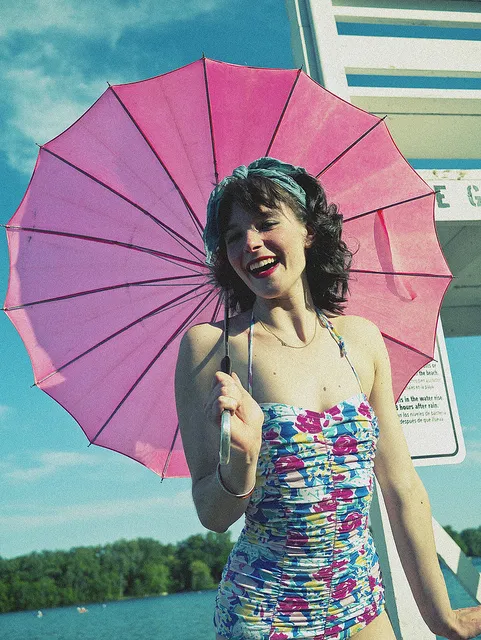
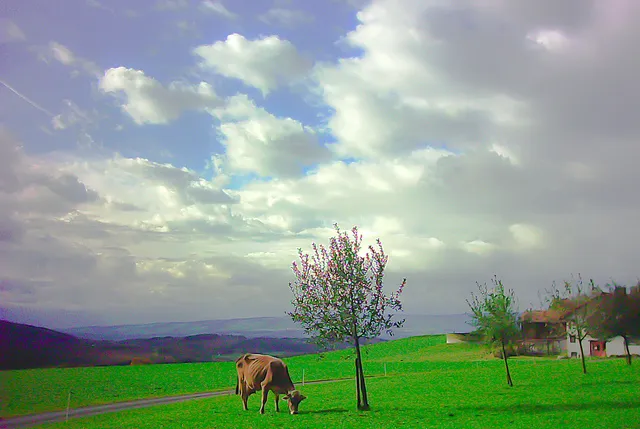

In [9]:
# View extracted data
t.select(t.image, t.data, t.data['choices'][0]['message']['content']).collect()

image,description
,"A woman holding a pink umbrella and wearing a colorful swimsuit, smiling against a backdrop of a lake and blue sky."
,A serene landscape featuring a cow grazing in a green field with a tree and distant buildings under a partly cloudy sky.

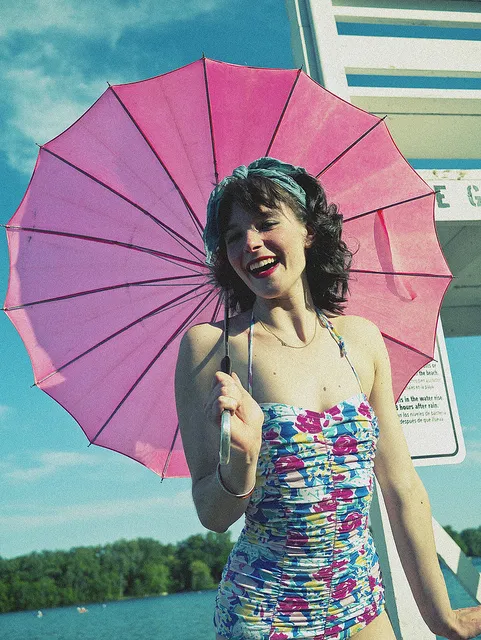
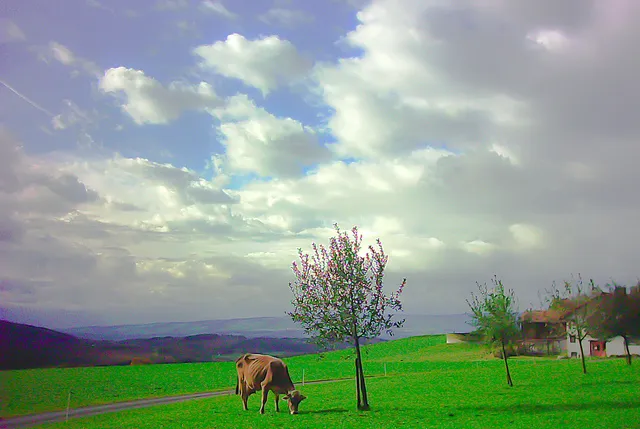

In [11]:
# You can also parse the JSON into individual columns if needed
import json


@pxt.udf
def parse_description(data: str) -> str:
    return json.loads(data).get('description', '')


t.select(t.image, description=parse_description(t.data['choices'][0]['message']['content'])).collect()

## Explanation

**Getting JSON output:**

Pass `model_kwargs={'response_format': {'type': 'json_object'}}` to get structured JSON.

**Other extraction use cases:**

| Use Case | Fields to extract |
|----------|------------------|
| Receipts | vendor, total, date, items, tax |
| Business cards | name, title, company, email, phone |
| Product photos | brand, model, condition, defects |
| Documents | title, date, author, summary |

## See also

- [Analyze images in batch](https://docs.pixeltable.com/howto/cookbooks/images/vision-batch-analysis)
- [Configure API keys](https://docs.pixeltable.com/howto/cookbooks/core/workflow-api-keys)